In [11]:
library(diversedata)
library(tidyverse)
library(AER)
library(broom)
library(knitr)
library(MASS)

Loading required package: car



Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some


Loading required package: lmtest

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: sandwich

Loading required package: survival


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




In [12]:
# Reading Data
marchmadness <- womensmarchmadness

# Review total rows
nrow(marchmadness)

[1] 2092

In [13]:
# Removing NA but only in selected columns
marchmadness <- marchmadness |> drop_na(seed, tourney_wins)

# Notice no rows were removed
nrow(marchmadness)

[1] 2092

In [14]:
marchmadness <- marchmadness |> 
  filter(seed != 0)

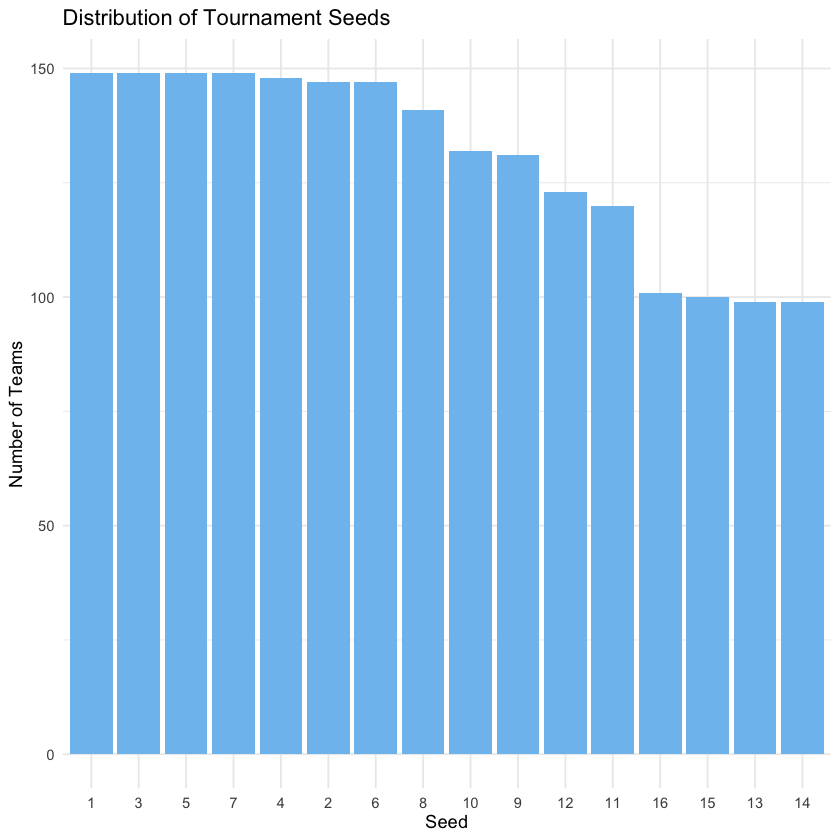

In [15]:
seed_count <- marchmadness |> 
  count(seed) |> 
  arrange(desc(n)) |>
  mutate(seed = factor(seed, levels = seed))

ggplot(
  seed_count, 
  aes(x = seed, y = n)
  ) +
  geom_col(fill = "skyblue2") +
  labs(
    title = "Distribution of Tournament Seeds",
    x = "Seed",
    y = "Number of Teams") +
  theme_minimal()

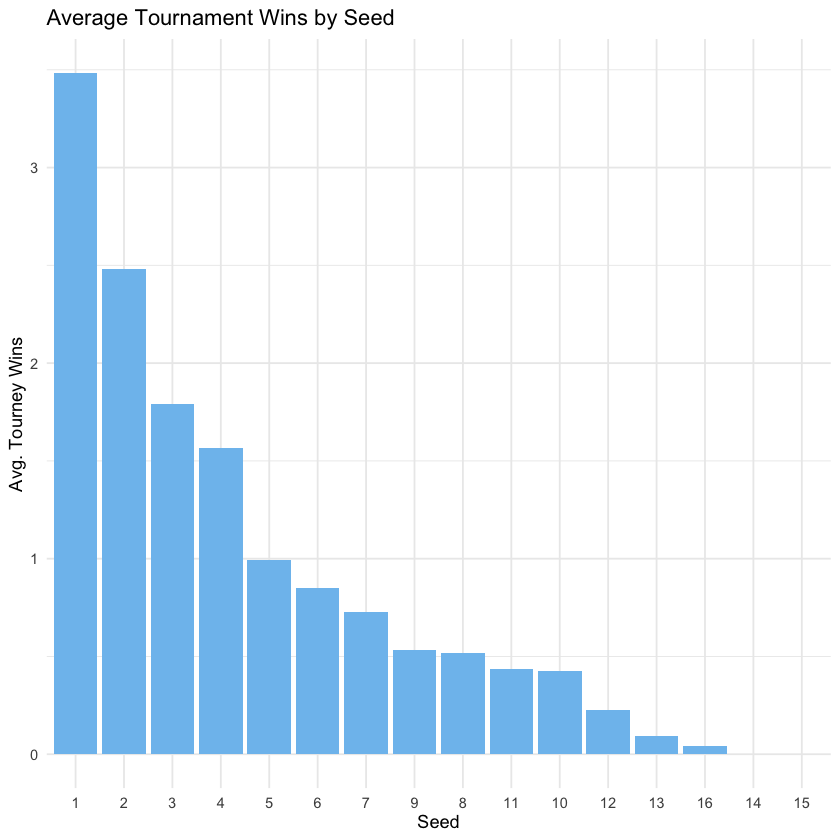

In [16]:
marchmadness |> 
  filter(!is.na(seed), seed != 0) |> 
  group_by(seed) |> 
  summarise(
    avg_tourney_wins = mean(tourney_wins, na.rm = TRUE)
    ) |>
  arrange(desc(avg_tourney_wins)) |>
  mutate(seed = factor(seed, levels = seed)) |>
  ggplot(
    aes(
      x = as.factor(seed),
      y = avg_tourney_wins)
    ) +
  geom_col(fill = "skyblue2") +
  labs(
    title = "Average Tournament Wins by Seed",
    x = "Seed",
    y = "Avg. Tourney Wins"
  ) +
  theme_minimal()

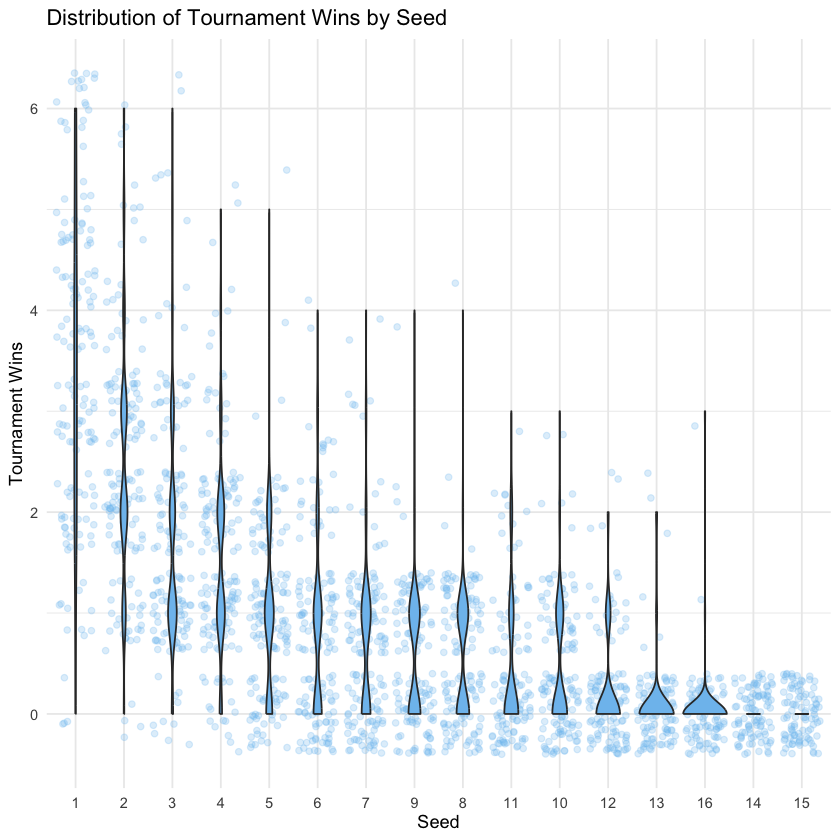

In [17]:
seed_order <- marchmadness |> 
  filter(!is.na(seed), seed != 0) |> 
  group_by(seed) |> 
  summarise(avg_wins = mean(tourney_wins, na.rm = TRUE)) |> 
  arrange(desc(avg_wins)) |> 
  pull(seed)

marchmadness |> 
  filter(!is.na(seed), seed != 0) |> 
  mutate(seed = factor(seed, levels = seed_order)) |> 
  ggplot(
    aes(x = seed, y = tourney_wins)
  ) +
  geom_jitter(alpha = 0.25, color = "skyblue2") +
  geom_violin(fill = "skyblue2") +
  labs(
    title = "Distribution of Tournament Wins by Seed",
    x = "Seed",
    y = "Tournament Wins"
  ) +
  theme_minimal()

In [18]:
marchmadness_factor <- marchmadness |> 
  mutate(seed = as.ordered(seed)) |> 
  mutate(seed = fct_relevel
         (seed, 
           c("1", "2", "3", "4", "5", 
             "6", "7", "8", "9", "10", 
             "11", "12", "13", "14", "15", 
             "16")))

In [19]:
options(contrasts = c("contr.treatment", "contr.sdif"))

poisson_model <- glm(tourney_wins ~ seed, family = "poisson", data = marchmadness)

poisson_model_factor <- glm(tourney_wins ~ seed, family = "poisson", data = marchmadness_factor)

`geom_smooth()` using formula = 'y ~ x'


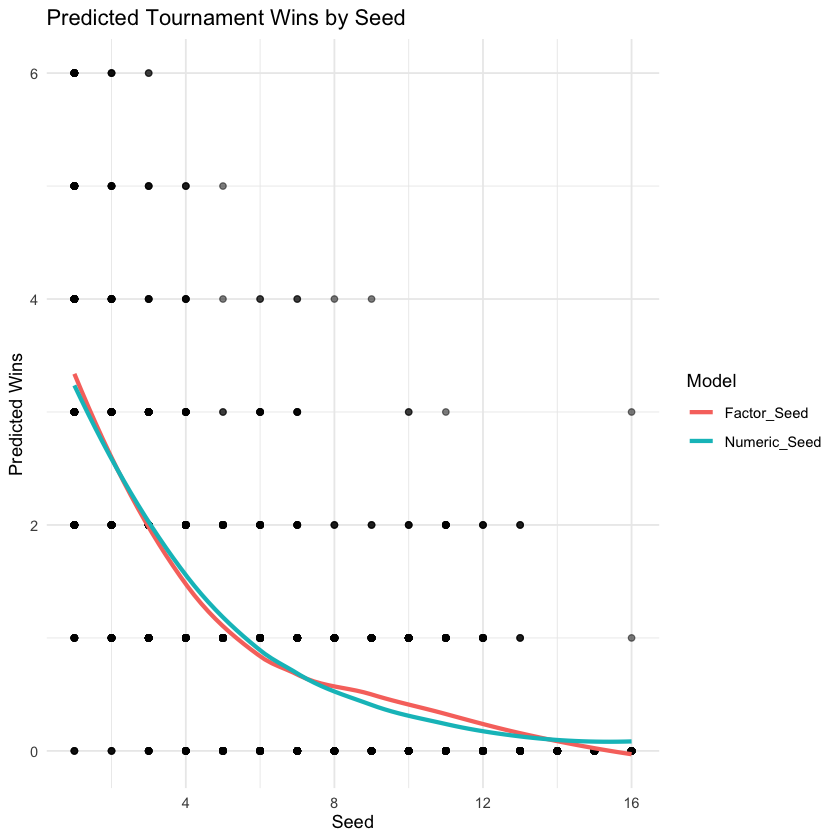

In [20]:
marchmadness <- marchmadness |> 
  mutate(
    Numeric_Seed = predict(poisson_model, type = "response"),
    Factor_Seed = predict(poisson_model_factor, type = "response")
  )

plot_data <- marchmadness |> 
  dplyr::select(seed, tourney_wins, Numeric_Seed, Factor_Seed) |> 
  pivot_longer(cols = c("Numeric_Seed","Factor_Seed"), names_to = "model", values_to = "predicted")

ggplot(plot_data, aes(x = seed, y = predicted, color = model)) +
  geom_point(aes(y = tourney_wins), alpha = 0.3, color = "black") +
  geom_line(stat = "smooth", method = "loess", se = FALSE, linewidth = 1.2) +
  labs(title = "Predicted Tournament Wins by Seed",
       x = "Seed",
       y = "Predicted Wins",
       color = "Model") +
  theme_minimal()

In [21]:
kable(glance(poisson_model), digits = 2)



| null.deviance| df.null|   logLik|     AIC|     BIC| deviance| df.residual| nobs|
|-------------:|-------:|--------:|-------:|-------:|--------:|-----------:|----:|
|       3438.76|    2083| -2117.42| 4238.84| 4250.12|  1610.34|        2082| 2084|

In [22]:
kable(glance(poisson_model_factor), digits = 2)



| null.deviance| df.null|   logLik|     AIC|     BIC| deviance| df.residual| nobs|
|-------------:|-------:|--------:|-------:|-------:|--------:|-----------:|----:|
|       3438.76|    2083| -2079.52| 4191.04| 4281.31|  1534.54|        2068| 2084|

In [23]:
anova_result <- tidy(anova(poisson_model, poisson_model_factor, test = "Chisq"))

kable(anova_result, digits = 2) 



|term                | df.residual| residual.deviance| df| deviance| p.value|
|:-------------------|-----------:|-----------------:|--:|--------:|-------:|
|tourney_wins ~ seed |        2082|           1610.34| NA|       NA|      NA|
|tourney_wins ~ seed |        2068|           1534.54| 14|    75.79|       0|

In [24]:
kable(tidy(dispersiontest(poisson_model_factor)), digits = 2)



| estimate| statistic| p.value|method              |alternative |
|--------:|---------:|-------:|:-------------------|:-----------|
|     0.96|     -0.56|    0.71|Overdispersion test |greater     |

In [25]:
summary_model <- tidy(poisson_model_factor) |> 
  mutate(exp_estimate = exp(estimate)) |> 
  mutate_if(is.numeric, round, 3) |> 
  filter(p.value <= 0.05)
  
kable(summary_model, digits = 2)



|term      | estimate| std.error| statistic| p.value| exp_estimate|
|:---------|--------:|---------:|---------:|-------:|------------:|
|seed2-1   |    -0.34|      0.07|     -4.96|    0.00|         0.71|
|seed3-2   |    -0.33|      0.08|     -4.05|    0.00|         0.72|
|seed5-4   |    -0.46|      0.10|     -4.34|    0.00|         0.63|
|seed8-7   |    -0.34|      0.15|     -2.22|    0.03|         0.71|
|seed12-11 |    -0.64|      0.23|     -2.75|    0.01|         0.52|
|seed13-12 |    -0.92|      0.38|     -2.40|    0.02|         0.40|

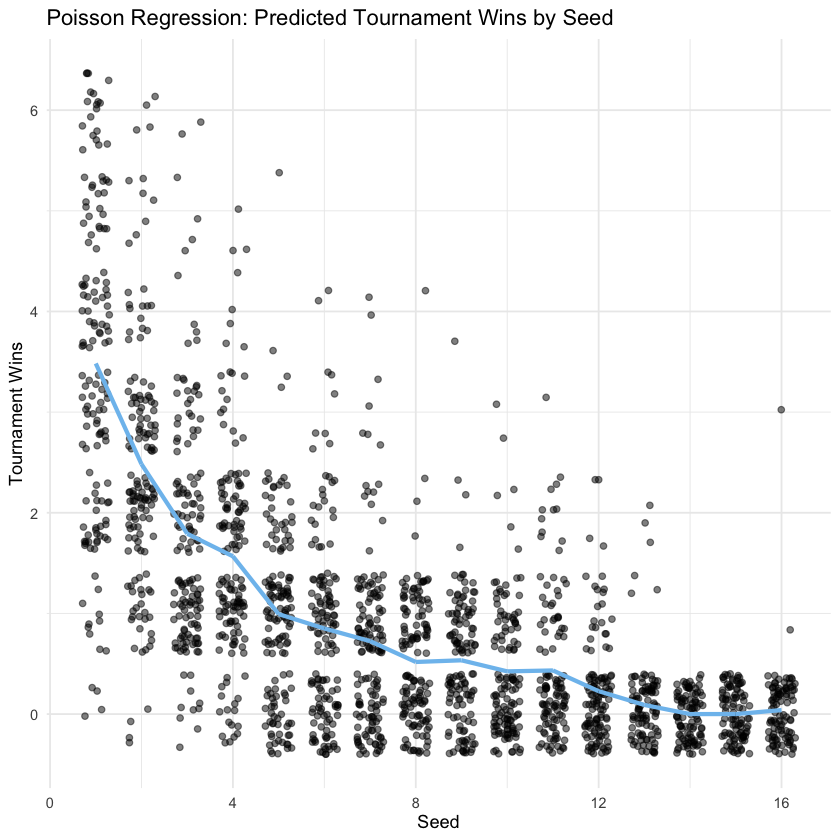

In [26]:
marchmadness$predicted_wins <- predict(poisson_model_factor, type = "response")

model_plot <- ggplot(marchmadness, aes(x = seed, y = tourney_wins)) +
  geom_jitter(width = 0.3, alpha = 0.5) +
  geom_line(aes(y = predicted_wins), color = "skyblue2", linewidth = 1.2) +
  labs(title = "Poisson Regression: Predicted Tournament Wins by Seed",
       x = "Seed",
       y = "Tournament Wins") +
  theme_minimal()

model_plot